In [1]:
#Coding our own Feed Forward Neural Network using python.
#Importing libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import seaborn as sns
from pathlib import Path





# Figure output directory
RESULTS_DIR = Path("results").resolve()
FIGURES_DIR = RESULTS_DIR / "figures"

# Create them if they dont exist
if not RESULTS_DIR.exists():
    RESULTS_DIR.mkdir()

if not FIGURES_DIR.exists():
    FIGURES_DIR.mkdir()

#Setting the random seed, obtaining always the same output for random generated variables
np.random.seed(2023)
#Generating our dataset, we choose to use the Franke Function.
def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

x = np.arange(0, 1, 0.1)
y = np.arange(0, 1, 0.1)
x, y = np.meshgrid(x,y)

#np.random.normal() adds noise to z with a normal distribution.
z = FrankeFunction(x, y) + 0.01*np.random.normal(0,1, x.shape)


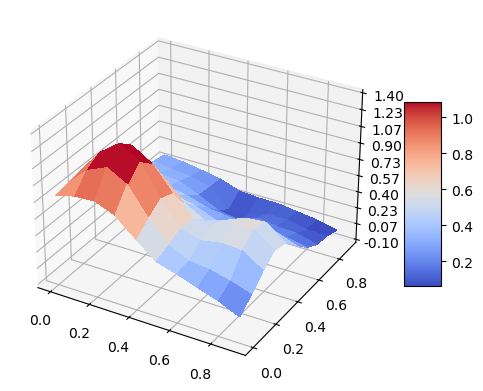

In [2]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
# Plot the surface.
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [3]:
#reshaping the meshgrid in two arrays
x = x.reshape(-1,1) 
y = y.reshape(-1,1)
z = z.reshape(-1,1)
X = np.hstack((x,y))

In [4]:
# Hold out some test data that is not used in training.
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)

In [5]:
#Initializing the layers size, we chose to use one hidden layer.
#the output is only one node since we have one possible output.
n_inputs, n_features = X_train.shape
hid = 10
out = 1

In [6]:
#Initializing weights and bias in the hidden layer
hidden_weights = np.random.randn(n_features, hid)
hidden_bias = np.zeros(hid) + 0.01

#Initializing weights and bias in the output layer
output_weights = np.random.randn(hid, out)
output_bias = np.zeros(out) + 0.01

In [7]:

def relu(X):
    return np.where(X > np.zeros(X.shape), X, np.zeros(X.shape))

#define linear function, we'll use it for the output since we have a continous output.
#It's here just for showing how it's defined, but since the linear funcion is just returning the value of the parameter, we won't need to use it later in the code.
def linear(x):
    return x

In [8]:
#we now define the cost/loss function. We use the MSE.
def MSE(y_data,y_model):
    n = np.size(y_model)
    y_data = y_data.reshape(-1,1)
    y_model = y_model.reshape(-1,1)
    return np.sum((y_data-y_model)**2)/n

#We define the R square
def rsquare(y, ypredict):
    y = y.reshape(-1, 1)
    ypredict = ypredict.reshape(-1,1)
    return 1-(np.sum((y-ypredict)**2)/np.sum((y-np.mean(y))**2))


In [10]:
def feed_forward(X):
    # weighted sum of inputs to the hidden layer
    z_h = np.matmul(X, hidden_weights) + hidden_bias
    # activation in the hidden layer
    a_h = relu(z_h)
    # weighted sum of inputs to the output layer
    z_o = np.matmul(a_h, output_weights) + output_bias
    
    return z_o

#feed forward stops before the output
def feed_forw_hid(X):
    # weighted sum of inputs to the hidden layer
    z_h = np.matmul(X, hidden_weights) + hidden_bias
    # activation in the hidden layer
    a_h = relu(z_h)
    return a_h

In [11]:
#We define the backpropagation algorithm
def backpropagation(X,Y):
    a_h = feed_forw_hid(X)
    #output error
    output_error = feed_forward(X) - Y
    #hidden error
    hidden_error = np.matmul(output_error, output_weights.T) * a_h * (1 - a_h)

    # gradients for the output layer
    output_weights_gradient = np.matmul(a_h.T, output_error)
    output_bias_gradient = np.sum(output_error, axis=0)
    
    # gradient for the hidden layer
    hidden_weights_gradient = np.matmul(X.T, hidden_error)
    hidden_bias_gradient = np.sum(hidden_error, axis=0)
    #Updated weights and bias are returned
    return output_weights_gradient, output_bias_gradient, hidden_weights_gradient, hidden_bias_gradient


In [12]:
#We code the learning algorithm
num_epochs = 1000
#We declare eta and lambda. all these values are going to get "tested" in order to find the best couple.
eta = [0.001, 0.003, 0.005, 0.007, 0.009, 0.011, 0.013, 0.015]
lmbd = [0.001, 0.003, 0.005, 0.007, 0.009, 0.011, 0.013, 0.015]
#Declaring the mse and r2 for train and test. 
#they are matrixes and get their values when learning.
loss_train = np.zeros((len(lmbd),len(eta)))
r2_train = np.zeros((len(lmbd),len(eta)))
loss_test = np.zeros((len(lmbd),len(eta)))
r2_test = np.zeros((len(lmbd),len(eta)))

In [13]:
#We define the learning of the NN.
def learn(ld, et, o_w, o_b, h_w, h_b):
        for epoch in range(num_epochs):
                # calculate gradients
                dWo, dBo, dWh, dBh = backpropagation(X_train, z_train)    
                #regularization term gradients
                dWo += ld * output_weights
                dWh += ld * hidden_weights

                #update weights and biases
                o_w -= et * dWo
                o_b -= et * dBo
                h_w -= et * dWh
                h_b -= et * dBh
        #we find the loss by calculating the mse with the predicted value and the actual value.
        #We find mse for train and test.
        ls = MSE(z_train, feed_forward(X_train))
        r = rsquare(z_train, feed_forward(X_train))
        ls_test = MSE(z_test, feed_forward(X_test))
        r_test = rsquare(z_test, feed_forward(X_test))
        return ls, r, ls_test, r_test

In [14]:

loss_best = 1
#We make the NN learn with each combination of parameters.
for i in range(len(lmbd)):
    for j in range(len(eta)):
        loss_train[j][i], r2_train[j][i], loss_test[j][i], r2_test[j][i] = learn(lmbd[i], eta[j], output_weights, output_bias, hidden_weights, hidden_bias)
        #finding the best values of eta and lambda for mse.
        if loss_test[j][i] < loss_best:
            loss_best = loss_test[j][i]
            best_lmbd = lmbd[i]
            best_eta = eta[j]
            j_b = j
            i_b = i
        print(f'TRAIN {j},{i} Loss: {loss_train[j][i]}, R2 {r2_train[j][i]}')
        print(f'TEST {j},{i} Loss: {loss_test[j][i]}, R2 {r2_test[j][i]}')


TRAIN 0,0 Loss: 0.01840221366576451, R2 0.7475591953443993
TEST 0,0 Loss: 0.02097714527824103, R2 0.7700528468068928
TRAIN 1,0 Loss: nan, R2 nan
TEST 1,0 Loss: nan, R2 nan


C:\Users\user\AppData\Local\Temp\ipykernel_6164\4179508732.py:7: RuntimeWarning: overflow encountered in matmul
  z_o = np.matmul(a_h, output_weights) + output_bias
C:\Users\user\AppData\Local\Temp\ipykernel_6164\472268084.py:7: RuntimeWarning: invalid value encountered in multiply
  hidden_error = np.matmul(output_error, output_weights.T) * a_h * (1 - a_h)
C:\Users\user\AppData\Local\Temp\ipykernel_6164\472268084.py:10: RuntimeWarning: invalid value encountered in matmul
  output_weights_gradient = np.matmul(a_h.T, output_error)
C:\Users\user\AppData\Local\Temp\ipykernel_6164\472268084.py:14: RuntimeWarning: invalid value encountered in matmul
  hidden_weights_gradient = np.matmul(X.T, hidden_error)


TRAIN 2,0 Loss: nan, R2 nan
TEST 2,0 Loss: nan, R2 nan
TRAIN 3,0 Loss: nan, R2 nan
TEST 3,0 Loss: nan, R2 nan
TRAIN 4,0 Loss: nan, R2 nan
TEST 4,0 Loss: nan, R2 nan
TRAIN 5,0 Loss: nan, R2 nan
TEST 5,0 Loss: nan, R2 nan
TRAIN 6,0 Loss: nan, R2 nan
TEST 6,0 Loss: nan, R2 nan
TRAIN 7,0 Loss: nan, R2 nan
TEST 7,0 Loss: nan, R2 nan
TRAIN 0,1 Loss: nan, R2 nan
TEST 0,1 Loss: nan, R2 nan
TRAIN 1,1 Loss: nan, R2 nan
TEST 1,1 Loss: nan, R2 nan
TRAIN 2,1 Loss: nan, R2 nan
TEST 2,1 Loss: nan, R2 nan
TRAIN 3,1 Loss: nan, R2 nan
TEST 3,1 Loss: nan, R2 nan
TRAIN 4,1 Loss: nan, R2 nan
TEST 4,1 Loss: nan, R2 nan
TRAIN 5,1 Loss: nan, R2 nan
TEST 5,1 Loss: nan, R2 nan
TRAIN 6,1 Loss: nan, R2 nan
TEST 6,1 Loss: nan, R2 nan
TRAIN 7,1 Loss: nan, R2 nan
TEST 7,1 Loss: nan, R2 nan
TRAIN 0,2 Loss: nan, R2 nan
TEST 0,2 Loss: nan, R2 nan
TRAIN 1,2 Loss: nan, R2 nan
TEST 1,2 Loss: nan, R2 nan
TRAIN 2,2 Loss: nan, R2 nan
TEST 2,2 Loss: nan, R2 nan
TRAIN 3,2 Loss: nan, R2 nan
TEST 3,2 Loss: nan, R2 nan
TRAIN 4,2 

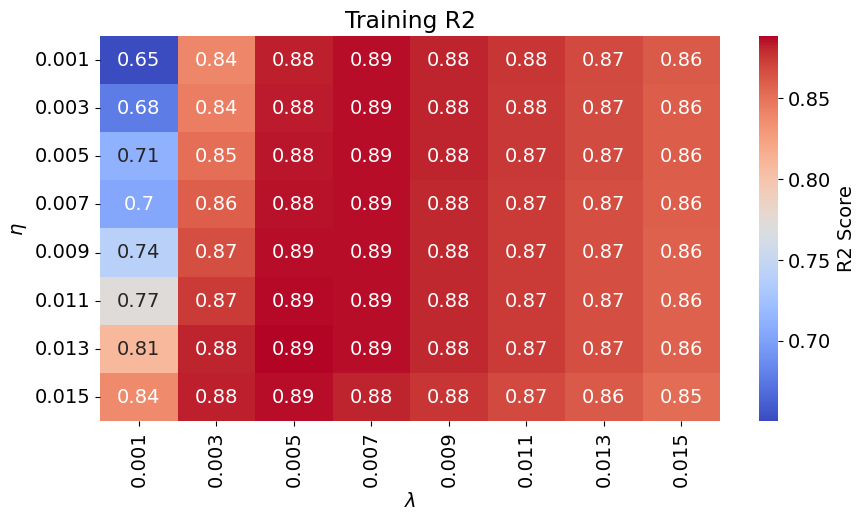

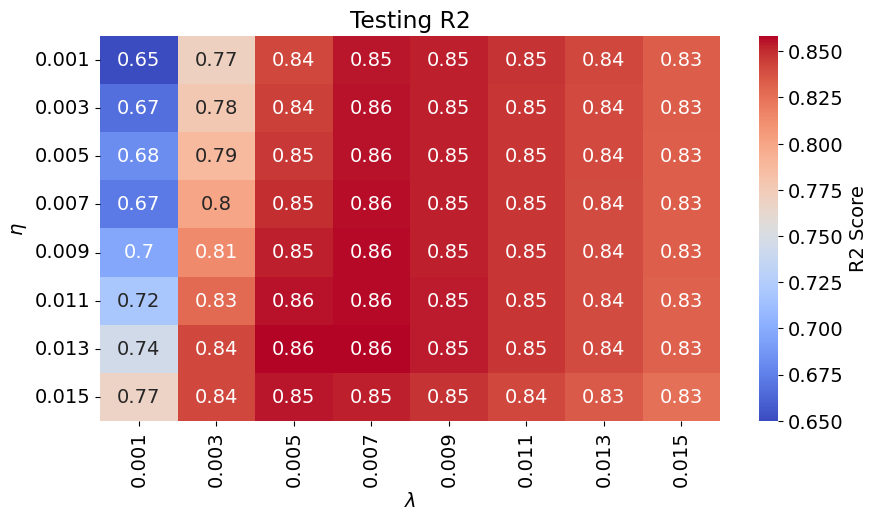

In [85]:
# Set custom tick labels to show eta and lambda values instead of index
fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(r2_train, annot=True, ax=ax, cmap="coolwarm", cbar_kws={'label': 'R2 Score'})
ax.set_title("Training R2")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
ax.set_yticks(np.arange(len(eta)) + 0.5)
ax.set_yticklabels([f"{v:.3f}" for v in eta], rotation=0)
ax.set_xticks(np.arange(len(lmbd)) + 0.5)
ax.set_xticklabels([f"{v:.3f}" for v in lmbd], rotation=90)
plt.savefig(FIGURES_DIR / "R2_FFNN_train.png")
plt.show()

# Testing R2 heatmap
fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(r2_test, annot=True, ax=ax, cmap="coolwarm", cbar_kws={'label': 'R2 Score'})
ax.set_title("Testing R2")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")

# Set custom tick labels to show eta and lambda values instead of index
ax.set_yticks(np.arange(len(eta)) + 0.5)
ax.set_yticklabels([f"{v:.3f}" for v in eta], rotation=0)
ax.set_xticks(np.arange(len(lmbd)) + 0.5)
ax.set_xticklabels([f"{v:.3f}" for v in lmbd], rotation=90)
plt.savefig(FIGURES_DIR / "R2_FFNN_test.png")
plt.show()



In [84]:
print(f'The best parameters are:')
print(f'Lambda = {best_lmbd}')
print(f'Eta = {best_eta}')
print(f'{j_b},{i_b}')
print(f'The results with these parameters are:')
print(f'MSE: {loss_test[j_b][i_b]}')
print(f'R2: {r2_test[j_b][i_b]}')

The best parameters are:
Lambda = 0.005
Eta = 0.013
6,2
The results with these parameters are:
MSE: 0.012927600895358438
R2: 0.8582902971746211


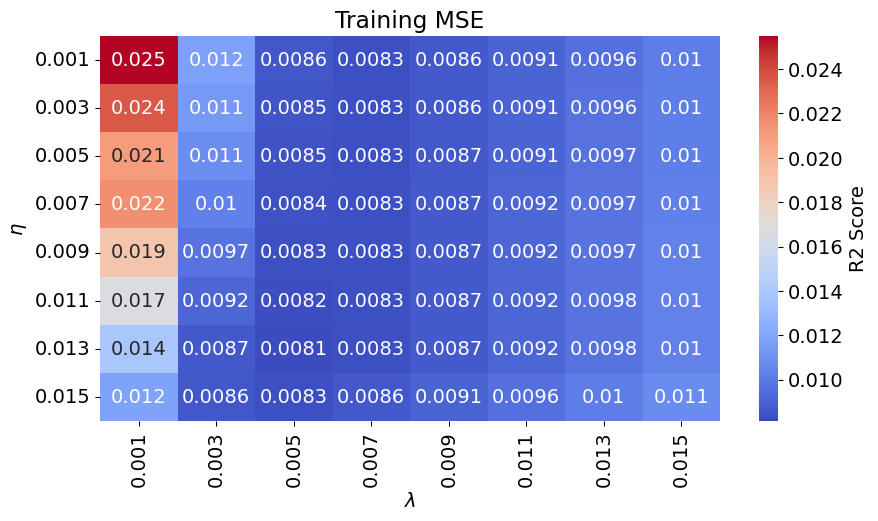

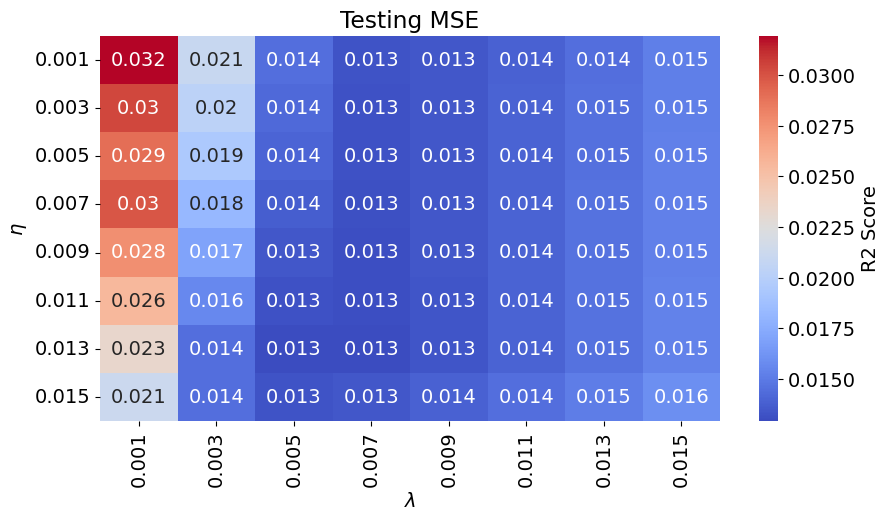

In [87]:
# Set custom tick labels to show eta and lambda values instead of index
fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(loss_train, annot=True, ax=ax, cmap="coolwarm", cbar_kws={'label': 'R2 Score'})
ax.set_title("Training MSE")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
ax.set_yticks(np.arange(len(eta)) + 0.5)
ax.set_yticklabels([f"{v:.3f}" for v in eta], rotation=0)
ax.set_xticks(np.arange(len(lmbd)) + 0.5)
ax.set_xticklabels([f"{v:.3f}" for v in lmbd], rotation=90)
plt.savefig(FIGURES_DIR / "MSE_FFNN_train.png")
plt.show()

# Testing R2 heatmap
fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(loss_test, annot=True, ax=ax, cmap="coolwarm", cbar_kws={'label': 'R2 Score'})
ax.set_title("Testing MSE")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")

# Set custom tick labels to show eta and lambda values instead of index
ax.set_yticks(np.arange(len(eta)) + 0.5)
ax.set_yticklabels([f"{v:.3f}" for v in eta], rotation=0)
ax.set_xticks(np.arange(len(lmbd)) + 0.5)
ax.set_xticklabels([f"{v:.3f}" for v in lmbd], rotation=90)
plt.savefig(FIGURES_DIR / "MSE_FFNN_test.png")
plt.show()



In [22]:
# Importing necessary libraries for FFNN and evaluation
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Scale the input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the MLPRegressor model (FFNN)
# Here we choose 2 hidden layers with 50 neurons each, but you can adjust as needed.
ffnn = MLPRegressor(hidden_layer_sizes=(50, 50),  # Two hidden layers with 50 neurons each
                    activation='relu',           # Using ReLU activation function
                    alpha=0.005,                 # Regularization term (lambda)
                    learning_rate_init=0.01,     # Adjusted initial learning rate (eta)
                    max_iter=2000,               # Increased max iterations for training
                    solver='adam', 
                    random_state=2023)

# Train the model
ffnn.fit(X_train_scaled, z_train.ravel())

# Predict on training and test data
z_train_pred = ffnn.predict(X_train_scaled)
z_test_pred = ffnn.predict(X_test_scaled)

# Calculate MSE for training and test data
train_mse_custom = MSE(z_train, z_train_pred)
test_mse_custom = MSE(z_test, z_test_pred)

# Calculate MSE using sklearn's mean_squared_error for verification
train_mse_sklearn = mean_squared_error(z_train, z_train_pred)
test_mse_sklearn = mean_squared_error(z_test, z_test_pred)

# Print the results
print("Training MSE (custom):", train_mse_custom)
print("Test MSE (custom):", test_mse_custom)
print("Training MSE (sklearn):", train_mse_sklearn)
print("Test MSE (sklearn):", test_mse_sklearn)



Training MSE (custom): 0.0007497306748085944
Test MSE (custom): 0.002049654184174389
Training MSE (sklearn): 0.0007497306748085944
Test MSE (sklearn): 0.002049654184174389
